### Simple POP model works

In [1]:
include("../LiPoSID.jl")
#using QuantumOptics
#basis = NLevelBasis(2)
using DynamicPolynomials
using LinearAlgebra
using Dates
using HDF5
using TSSOS

Consider simple Lindblad master equation with just one dissipator:

$m
     \frac{d\rho}{dt} = - \frac{i}{\hbar}[H, \rho]+\gamma\left[J \rho J^\dagger - \frac{1}{2}\left\{ J^\dagger J, \rho \right\} \right]
$,

where Hamiltonian is hermitian with one of the diagonal elemnets set to zero


$
    H = \begin{pmatrix} w & 0 \\ 0 & 0
   \end{pmatrix}
$

 withot loss of generality we can possibly look for jump operator of the form:

$
J = \begin{pmatrix} 0 & g \\ 0 & 0 
   \end{pmatrix} 
$


In [2]:
@polyvar w
@polyvar g


Hˢʸᵐᵇ = [ w  0
          0     0. ]

2×2 Matrix{Term{true, Float64}}:
 w    0.0
 0.0  0.0

In [3]:
method = "ansatz"

@polyvar a[1:4]
@polyvar b[1:4]


Jˢʸᵐᵇ = [ 0   g
          0   0 ]


2×2 Matrix{Term{true, Int64}}:
 0  g
 0  0

In [5]:
data_dir = "../DATA/"
println(data_dir)

models_dir = "../MODELS/"
tests_dir = "../TESTS/"

dodeca_files = ["State_D"*string(n) for n=1:20];

basis_files = ["State_B"*string(n) for n=1:4];

../DATA/


In [6]:
all_files = vcat(dodeca_files, basis_files)
train_files = basis_files 
test_files = dodeca_files;

In [7]:
function scaling_poly(p::Polynomial)

    X = transpose(hcat([exponents(t) for t in terms(p)]...))

    # Get the scaling via linear regression
    scaling = X \ log.(abs.(coefficients(p)))

    exp.(abs.(scaling)) # 
end


function tssos_min(p)
    
    ################################################################################################
    #
    #   Try TSSOS on polynomial with scaled variables
    #
    ################################################################################################

    pd = p #/ maximum(abs.(coefficients(p)))

    # minimize
    # minimizer_scaled_tssos = nothing

    try
        opt,sol,data = tssos_first(pd, variables(pd), QUIET=true, solution=true, newton=true);
        previous_sol = sol

        while ~isnothing(sol)
            previous_sol = sol
            opt,sol,data = tssos_higher!(data; QUIET=true, solution=true);
        end

        global minimizer_tssos = previous_sol
    
    catch
        println("Scaled TSSOS failed")
        global minimizer_scaled_tssos = nothing

    end

    best_solution = variables(p) => minimizer_tssos

end

import Base.real

function coef_range(obj)
    maximum(abs.(coefficients(obj)))/minimum(abs.(coefficients(obj)))
end

using Optim
using Random

function local_rand_min(p)

    pd = p / maximum(abs.(coefficients(p)))

    # find variable scaling
    scale = scaling_poly(pd)

    # scale the polynomial
    p_scaled = subs(pd, variables(pd) => scale .* variables(pd))

    num_iterations = 100

    # Initialize the best minimizer and the minimum value
    best_minimizer = nothing
    best_min_value = Inf

    num_of_variables = length(variables(pd))

    for _ in 1:num_iterations
        # Generate a random initial condition
        initial_point = rand(num_of_variables).*250

        # Run local optimization
        result = Optim.optimize(p_scaled, initial_point, BFGS())
        #println(Optim.minimum(result))

        # Update the best minimizer if a better one is found
        if Optim.minimum(result) < best_min_value
            
            best_minimizer = Optim.minimizer(result)
            best_min_value = Optim.minimum(result)
            
        end

    end

    minimizer_scaled = scale .* best_minimizer

    solution = variables(p_scaled) => minimizer_scaled

end


local_rand_min (generic function with 1 method)

In [8]:
function g_objective(γᵢ)

    objₑₓ = 0

    for df_trn in train_files # loop over initial states

        ρᵗʳⁿ, tᵗʳⁿ = LiPoSID.get_rho_series(data_dir*df_trn*"_2CUT_data.h5", γᵢ)
        
        if length(tᵗʳⁿ) > 1200 end_train = 1200 else end_train = length(tᵗʳⁿ) end
            
        ρᵗʳⁿ = convert(Vector{Matrix{ComplexF64}}, ρᵗʳⁿ[1:end_train])
        
        tᵗʳⁿ = convert(Vector{Float64}, tᵗʳⁿ[1:end_train])

        objₑₓ += LiPoSID.simpson_obj(ρᵗʳⁿ, tᵗʳⁿ,  Hˢʸᵐᵇ, [Jˢʸᵐᵇ])
        
    end # of files (initial states) loop

    return(objₑₓ)
end

using Plots

function plot_objective(title_prompt, γᵢ)

    objective = g_objective(γᵢ)

    function f(w_val, g_val)
        return objective(variables(objective)[1] => w_val, variables(objective)[2] => g_val) #sqrt(abs(g_val))
    end

    w = range(-30, 30, length=1000)
    g = range(-10, 10, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(w', g)

    contour(w, g, log.(z), legend=false)#, margin=2, padding=2) # yaxis=:log, #xaxis=:log,
    #ylabel!("√γ")
    #heatmap(w, g, log.(z))
    title!(title_prompt*"\n\n γˢᵇ="*γᵢ)
    xlabel!("ω")
    ylabel!("\n\n √γ")
    scatter!([25.126], [sqrt(parse(Float64, γᵢ))], color=:green, legend=false)

end

function plot_objective_r(title_prompt, γᵢ)

    objective = g_objective(γᵢ)

    function f(w_val, g_val)
        return objective(variables(objective)[1] => w_val, variables(objective)[2] => g_val) #sqrt(abs(g_val))
    end

    w = range(-30, 30, length=1000)
    g = range(-10, 10, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(w', g)

    contour(w, g, log.(z), legend=false)#, margin=2, padding=2) # yaxis=:log, #xaxis=:log,
    #ylabel!("√γ")
    #heatmap(w, g, log.(z))
    title!(title_prompt*"\n\n γˢᵇ="*γᵢ)
    xlabel!("ω")
    ylabel!("\n\n √γ")
    scatter!([25.126], [sqrt(parse(Float64, γᵢ))], color=:green, legend=false)
    #title!("γ = "*γᵢ)

end

function plot_objective_l(title_prompt, γᵢ)

    objective = g_objective(γᵢ)

    function f(w_val, g_val)
        return objective(variables(objective)[1] => w_val, variables(objective)[2] => g_val) #sqrt(abs(g_val))
    end

    w = range(-30, 30, length=1000)
    g = range(-10, 10, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(w', g)

    contour(w, g, log.(z), legend=false)#, margin=2, padding=2) # yaxis=:log, #xaxis=:log,
    #ylabel!("√γ")
    #heatmap(w, g, log.(z))
    title!(title_prompt*"\n\n γˢᵇ="*γᵢ)
    xlabel!("ω")
    ylabel!("\n\n √γ")
    scatter!([25.126], [sqrt(parse(Float64, γᵢ))], color=:green, legend=false)
    
    

   
    #title!("γ = "*γᵢ)

end

plot_objective_l (generic function with 1 method)

In [165]:
plot11 = plot_objective_l("(a)","0.079477"); plot12 = plot_objective_r("(b)","0.25133")
plot21 = plot_objective_l("(c)","0.79477"); plot22 = plot_objective_r("(d)","2.5133")
plot31 = plot_objective_l("(e)","7.9477"); plot32 = plot_objective_r("(f)","25.133")
plot41 = plot_objective_l("(g)","79.477"); plot42 = plot_objective_r("(h)","251.33");

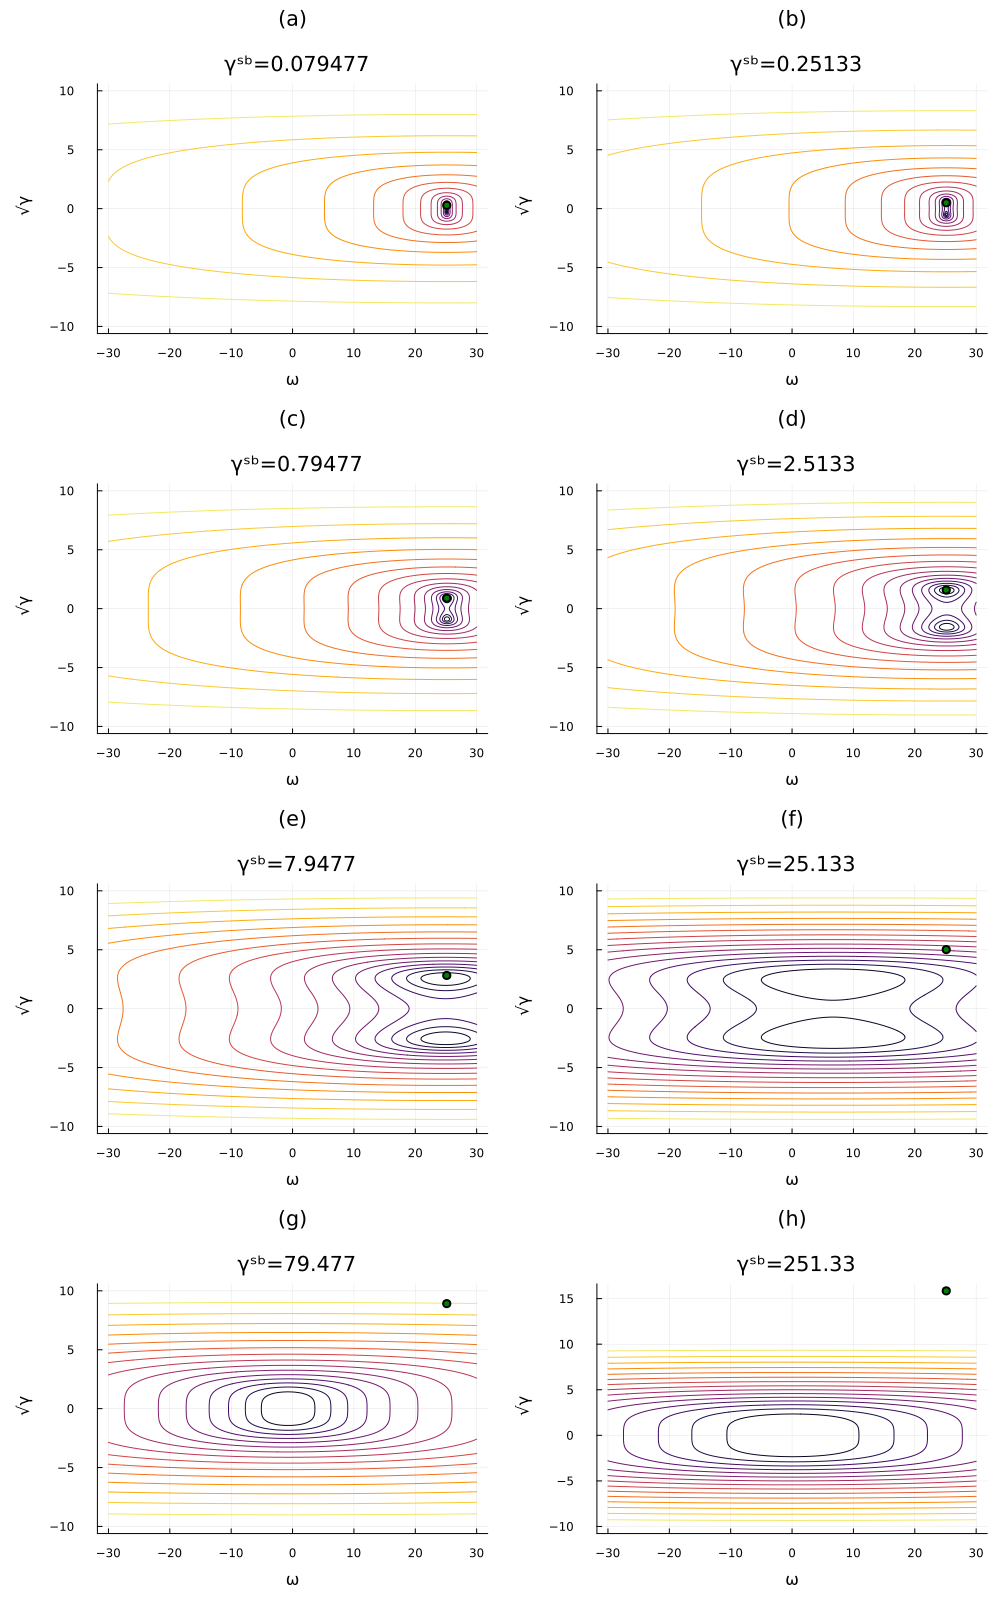

"/home/zah/github/OQSID-thesis/POP_LME/POP_LME_simple_objectives.pdf"

In [166]:
combined_plot = plot(plot11, plot12, plot21, plot22, plot31, plot32, plot41, plot42, layout=(4,2), size=(1000,1600))
#combined_plot = ylabel!("√γ")
display(combined_plot)
savefig(combined_plot, "POP_LME_simple_objectives.pdf")

In [10]:
using DynamicPolynomials, Serialization

γᵢ = "0.079477"

# Define a multivariate polynomial
objective = g_objective(γᵢ)

# Convert the polynomial to a string
p_str = string(objective)

# Save the string representation to a text file
open("pop_lme_obj_"*γᵢ*".txt", "w") do file
    write(file, p_str)
end



114

In [14]:
function save_objective(γᵢ)
    # Define a multivariate polynomial
    objective = g_objective(γᵢ)

    # Convert the polynomial to a string
    p_str = string(objective)

    file_path = "pop_lme_obj_"*γᵢ*".txt"

    # Save the string representation to a text file
    open(file_path, "w") do file
        write(file, p_str)
    end 

    print(file_path)

end

save_objective("2.5133")

pop_lme_obj_2.5133.txt